# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой группы, сравнить на графике

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [1]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [36]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6896075
access_token = '57b83c3959c6fb2fd16296585070aa5db7595841f40c2b6e186161909ac73c00bbe5e312b7115a2c478ea'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [45]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 10

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Александр Кузнецов


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [6]:
domains = ['ntv', 'tvrain']

for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    answer = vk_get_response(
        'groups.getMembers', f'group_id={group_id}&offset={offset}&fields={fields}&v=4.9&lang=ru', 
        token=access_token
    )['response']
    community_count = answer['count']
    community_members = []
    community_members.extend(answer['users'])
    print(f"{group_domain} offset: {offset}")
    for i in range(1, community_count//1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', f'group_id={group_id}&offset={offset}&fields={fields}&v=4.9&lang=ru', 
                token=access_token
            )['response'])
        except:
            print(f"{group_domain} offset: {offset} Error")
        community_members.extend(answer['users'])
    print(f"{group_domain} offset: {offset}")
    save_obj(community_members, f'{group_domain}_subs')

ntv offset: 0
ntv offset: 370000
tvrain offset: 0
tvrain offset: 444000


In [13]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')
len(community_ntv), len(community_tvrain)

(370502, 444124)

In [14]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [15]:
ntv_uids = community_ntv_df.uid.unique()
tvrain_uids = community_tvrain_df.uid.unique()
len(ntv_uids), len(tvrain_uids)

(370502, 444124)

Найдем пользователей, которые одновременно подписаны и на 'НТВ' и на 'Дождь'.

In [16]:
ntv_tvrain_intersect = np.intersect1d(ntv_uids, tvrain_uids)

In [17]:
len(ntv_tvrain_intersect)

17915

Таких пользователей оказалось 17915. Исключим их из рассмотрения.

In [18]:
np.random.seed(42)
ntv_uids = np.setdiff1d(ntv_uids, ntv_tvrain_intersect)
tvrain_uids = np.setdiff1d(tvrain_uids, ntv_tvrain_intersect)
# Получим случайную выборку пользователей по 1000 человек из каждой группы.
ntv_uids_sample = np.random.choice(ntv_uids, 1000)
tvrain_uids_sample = np.random.choice(tvrain_uids, 1000)
len(ntv_uids), len(tvrain_uids)

(352587, 426209)

In [19]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
uids = np.concatenate((ntv_uids_sample, tvrain_uids_sample))

In [51]:
# получить подписки этих пользователей
print_counter = 0
final_data = []
top_n = 5

for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', f'user_id={int(uid)}&v=4.9&lang=ru', access_token
        )['response']['groups']
        time.sleep(0.34)
        if user_subs['count']:
            user_subs['uid'] = uid
            user_subs['items'] = user_subs['items'][:top_n]
            final_data.append(user_subs)
            print_counter += 1
    except:
        pass
    if print_counter % 100 == 0:
        print(f"{print_counter} profiles done")

100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
500 profiles done
600 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1100 profiles done
1100 profiles done
1200 profiles done
1200 profiles done
1300 profiles done
1400 profiles done


In [53]:
save_obj(final_data, 'final_data')

In [11]:
final_data = load_obj('final_data')

In [12]:
print(f'Всего удалось скачать данные по {len(final_data)} пользователям')

Всего удалось скачать данные по 1453 пользователям


In [23]:
subs_list = []
groups_freq_dict = {}
top_n = 5
counter = 0

for record in final_data:
    subs_pd = pd.DataFrame(
        [
            {
                'uid': record.get('uid'),
                'groups_count': record.get('count'),
                'groups_list': record.get('items'),
            }
        ]
    )

    for group_id in record.get('items'):
        groups_freq_dict[group_id] = groups_freq_dict.get(group_id, 0) + 1
        
    subs_list.append(subs_pd)
    counter += 1
    if counter % 100 == 0:
        print(f"Processed {counter} users from each group")

Processed 100 users from each group
Processed 200 users from each group
Processed 300 users from each group
Processed 400 users from each group
Processed 500 users from each group
Processed 600 users from each group
Processed 700 users from each group
Processed 800 users from each group
Processed 900 users from each group
Processed 1000 users from each group
Processed 1100 users from each group
Processed 1200 users from each group
Processed 1300 users from each group
Processed 1400 users from each group


Самые популярные группы

In [14]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 215),
 (28658784, 138),
 (15755094, 46),
 (68519692, 38),
 (2158488, 37)]

In [15]:
print(f'Рассматриваемые пользователи подписаны на {len(groups_freq_dict)} групп.')

Рассматриваемые пользователи подписаны на 4349 групп.


Загрузка постов со стен групп

In [53]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id in groups_freq_dict_top5.keys():
    try:
        check = vk_get_response(
            'wall.get',
            f'owner_id={int(group_id) * -1}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru',
            access_token
        )['response']
        group_doc = []
        
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc.append(post['text'])
        group_doc_dict[group_id] = ''.join(group_doc)
        counter += 1
    except:
        print(f"Response error. Group id {group_id}")
#         print(check)
    if counter % 100 == 0:
        print(f"{counter} groups extracted")
    time.sleep(0.34)

100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
Response error. Group id 163822605
800 groups extracted
900 groups extracted
1000 groups extracted
1100 groups extracted
1200 groups extracted
1300 groups extracted
1400 groups extracted
1500 groups extracted
1600 groups extracted
1700 groups extracted
1800 groups extracted
1900 groups extracted
2000 groups extracted
2100 groups extracted
2200 groups extracted
2300 groups extracted
2400 groups extracted
2500 groups extracted
2600 groups extracted
2700 groups extracted
Response error. Group id 39758276
2800 groups extracted
2900 groups extracted
3000 groups extracted
3100 groups extracted
3200 groups extracted
3300 groups extracted
3400 groups extracted
3500 groups extracted
3600 groups extracted
3700 groups extracted
3800 groups extracted
3900 groups extracted
4000 groups extracted
4100 groups extracted
4200 groups extracted
4300 groups extr

In [55]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [16]:
group_doc_dict = load_obj('group_doc_dict')

In [17]:
print(f'Удалось скачать посты у {len(group_doc_dict)} групп.')

Удалось скачать посты у 4347 групп.


In [56]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [57]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016', u'март', u'2019', u'человек',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически', u'жизнь',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [58]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [59]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed
3800 docs processed
3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed


In [61]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

In [8]:
group_clean_doc_dict = load_obj('group_doc_dict_clean')
len(group_clean_doc_dict)

4347

### Обучение LDA модели

In [4]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc

In [9]:
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())

In [30]:
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=20
)

In [31]:
justlda.save('ldamodel_20_topics')

In [5]:
justlda =  LdaModel.load('ldamodel_20_topics')

In [32]:
justlda.get_topic_terms(0)

[(33168, 0.00034252758),
 (33291, 0.00030031122),
 (33530, 0.00029534794),
 (33457, 0.0002891249),
 (33248, 0.0002611556),
 (33271, 0.00026069002),
 (112118, 0.00026055588),
 (33372, 0.00025182817),
 (33246, 0.00024619952),
 (111990, 0.0002457369)]

In [125]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(20)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 5)

Group distribution by the most relevant topic


5     0.54543
9     0.18081
17    0.12583
16    0.06303
0     0.02599
4     0.02323
8     0.01771
19    0.01150
6     0.00437
14    0.00138
2     0.00023
1     0.00023
12    0.00023
dtype: float64

In [39]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 алып емес мена керека болс деген сағать жақс болада олара
АҚИҚАТҚА БІР ҚАДАМ http://vk.com/club81915170
♕ƏЛХАМДУЛИЛЛАҺ  МҰСЫЛМАНМЫН♕ http://vk.com/club91627267
Əльхамдулилляһ Мұсылманмын.🌙 http://vk.com/club129860775
Сабыр http://vk.com/club97007545
Лучшие видео в |KZ| 🇰🇿 http://vk.com/club68347204
BaGi http://vk.com/club61570847
Казахские песни http://vk.com/club58606308
Маған похуй http://vk.com/club76231763
♡ K-pop ♡ Корея дорамалары ♡ Ұлы ханша Сон Док ♡ http://vk.com/club84472333
ИСЛАМ жəне ОТБАСЫ | الإسلام والأسرة http://vk.com/club131225510

1 вперш новина продовжить території деякий замість результать офіційный акції дивіться
ТСН http://vk.com/club20035339
УНИАН | УНІАН http://vk.com/club24187484
Varta1 - Варта1 http://vk.com/club66210801
СТИХАЧ http://vk.com/club157826406
Так люблю той Львів, що бракує ми слів ;) http://vk.com/club24483285
Моя Україна : My Ukraine http://vk.com/club23282997
Действительно смешно http://vk.com/club232438

Слова Великих людей http://vk.com/club28981879
ЛайфХАК - своими руками http://vk.com/club49690338
Бордель • Скромно о нескромном http://vk.com/club35783559
Академия Порядочных Парней http://vk.com/club45595714
Казахские песни http://vk.com/club58606308

15 меpин стpанно hачинаета пpиезжать бpатка стаpый казеть 600-го стpёлка тpясет
Рабочий случай http://vk.com/club144447784
Наукомания http://vk.com/club157858886
Сочные GIF 18+ http://vk.com/club152751710
Анекдоты http://vk.com/club45179125
Безумный Челентано http://vk.com/club112290210
СОЮЗ ДЖИПЕРОВ http://vk.com/club24468460
Макияж 2019 http://vk.com/club36208551
Безумные приколы http://vk.com/club30751873
Бот Переводчик http://vk.com/club143321909
q http://vk.com/club21918262

16 группа новое запись видео друг альбом ссылка конкурс музыка проект
Russian Rock Club Русский Рок http://vk.com/club6116630
Институт Рокеров | Рок http://vk.com/club28043011
Zaycev.net http://vk.com/club34001496
ПОШЛАЯ МОЛЛИ http://vk.com/club114454317
Назойл

Топ 5 топиков:<br>
I. №5 Поэзия, философия, вера.<br>
II. №9 новости России и региональные новости.<br>
III. № 17 кулинария.<br>
IV. № 16 музыка, искусство.<br>
V. № 0 ислам, различные этнические паблики, в основном казахские.

In [126]:
# Создаим словарь в котором ключ - группа, значение - наиболее релевантный 
# для этой группы топик.
group_relevant_topic = {}
for group in groups_freq_dict.keys():
    group_topics = {}
    for i in range(20):
        try:
            group_topics[i] = check_pd_20[i][group]
        except:
            group_topics[i] = 0
    group_relevant_topic[group] = max(group_topics, key=group_topics.get) 

In [127]:
final_data[0]

{'count': 43,
 'items': [460389, 8722610, 12382740, 14848323, 18387878],
 'uid': 171904695}

In [128]:
ntv_uids_set = set(ntv_uids_sample)
tvrain_uids_set = set(tvrain_uids_sample)

Подсчитаем для каждого топика его взвешенный рейтинг. Для этого у каждого пользователя берется топ_5 групп. Каждая группа соотносится с топиком. Топик 1-й по популярности (у данного пользователя) группы получает 5 баллов, топик 5-й группы - 1 балл. Для каждого топика подсчитывается сумма оценок по всем пользователям и делится на общее количество пользьзователей данной группы ('НТВ' или 'Дождь').

In [129]:
ntv_users_topic_count = {key: 0 for key in range(20)}
n = len(ntv_uids_set)
for user_data in final_data:
    uid = user_data['uid']
    if uid in ntv_uids_set:
        for i, group in enumerate(user_data['items']):
            group_topic = group_relevant_topic[group]
            ntv_users_topic_count[group_topic] = ntv_users_topic_count[group_topic] + 5 - i
for k, v in ntv_users_topic_count.items():
    ntv_users_topic_count[k] = np.round(v/n, 5)

In [130]:
ntv_users_topic_count

{0: 0.26727,
 1: 0.003,
 2: 0.0,
 3: 0.0,
 4: 0.2002,
 5: 5.2953,
 6: 0.05906,
 7: 0.0,
 8: 0.11912,
 9: 2.58158,
 10: 0.0,
 11: 0.0,
 12: 0.004,
 13: 0.0,
 14: 0.06607,
 15: 0.0,
 16: 0.58559,
 17: 1.18919,
 18: 0.0,
 19: 0.1021}

In [131]:
tvrain_users_topic_count = {key: 0 for key in range(20)}
n = len(tvrain_uids_set)
for user_data in final_data:
    uid = user_data['uid']
    if uid in tvrain_uids_set:
        for i, group in enumerate(user_data['items']):
            group_topic = group_relevant_topic[group]
            tvrain_users_topic_count[group_topic] = tvrain_users_topic_count[group_topic] + 5 - i
for k, v in tvrain_users_topic_count.items():
    tvrain_users_topic_count[k] = np.round(v/n, 5)

In [132]:
tvrain_users_topic_count

{0: 0.174,
 1: 0.02,
 2: 0.001,
 3: 0.0,
 4: 0.15,
 5: 5.653,
 6: 0.077,
 7: 0.0,
 8: 0.12,
 9: 3.008,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.028,
 15: 0.0,
 16: 0.56,
 17: 0.942,
 18: 0.0,
 19: 0.082}

Составим словарь, где ключ - это номер топика, а значение - ключевые слова топика.

In [133]:
topics_dict = {}
for i in range(20):
    terms = justlda.get_topic_terms(i)
    topics_dict[i] = ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms))

In [134]:
topics_dict

{0: 'алып емес мена керека болс деген сағать жақс болада олара',
 1: 'вперш новина продовжить території деякий замість результать офіційный акції дивіться',
 2: 'would nice includ happen sinc australia decid kind month amsterdam',
 3: 'лафет класс📹 руки📹 изразцовый работа📹 подписчика📹 😍лестница супер📹 дoбычa работашикарный',
 4: 'авто комплект торг коробка продать передний привод двигатель пробег резина',
 5: 'знать любить жить друг думать любовь видеть найти понять смотреть',
 6: 'чтoб свoий бoльша кoгда когдa мeнить тoлько свoть сaмый тeбить',
 7: 'знать жить вместе думать любить город любимый неделя пара проблема',
 8: 'поверхность свойство применение воздействие нагрузка рекомендоваться способствовать метод эффективный эффект',
 9: 'россия российский житель территория сотрудник область регион район город участие',
 10: 'cахара сахаp куpиный мoлoтый очиcтить вaрить мяcый cтавим мелкo cладкий',
 11: 'друг центр любовь женщина вместе помочь любимый полный женский почему',
 12: '👜😻пода

Создадим DataFrame с усредненными оценками топиков для разных групп.

In [135]:
ntv_vs_tvrain_df = pd.DataFrame([topics_dict, ntv_users_topic_count, tvrain_users_topic_count]).T
ntv_vs_tvrain_df.columns = ['topics', 'ntv', 'tvrain']
ntv_vs_tvrain_df

,topics,ntv,tvrain
0,алып емес мена керека болс деген сағать жақс б...,0.26727,0.174
1,вперш новина продовжить території деякий заміс...,0.003,0.02
2,would nice includ happen sinc australia decid ...,0,0.001
3,лафет класс📹 руки📹 изразцовый работа📹 подписчи...,0,0
4,авто комплект торг коробка продать передний пр...,0.2002,0.15
5,знать любить жить друг думать любовь видеть на...,5.2953,5.653
6,чтoб свoий бoльша кoгда когдa мeнить тoлько св...,0.05906,0.077
7,знать жить вместе думать любить город любимый ...,0,0
8,поверхность свойство применение воздействие на...,0.11912,0.12
9,россия российский житель территория сотрудник ...,2.58158,3.008


In [136]:
ntv_vs_tvrain_df['topics'] = [str(i) + '. ' + topic[:50] +'\n' + \
        topic[50:100] for i, topic in enumerate(ntv_vs_tvrain_df.topics)]

Populating the interactive namespace from numpy and matplotlib


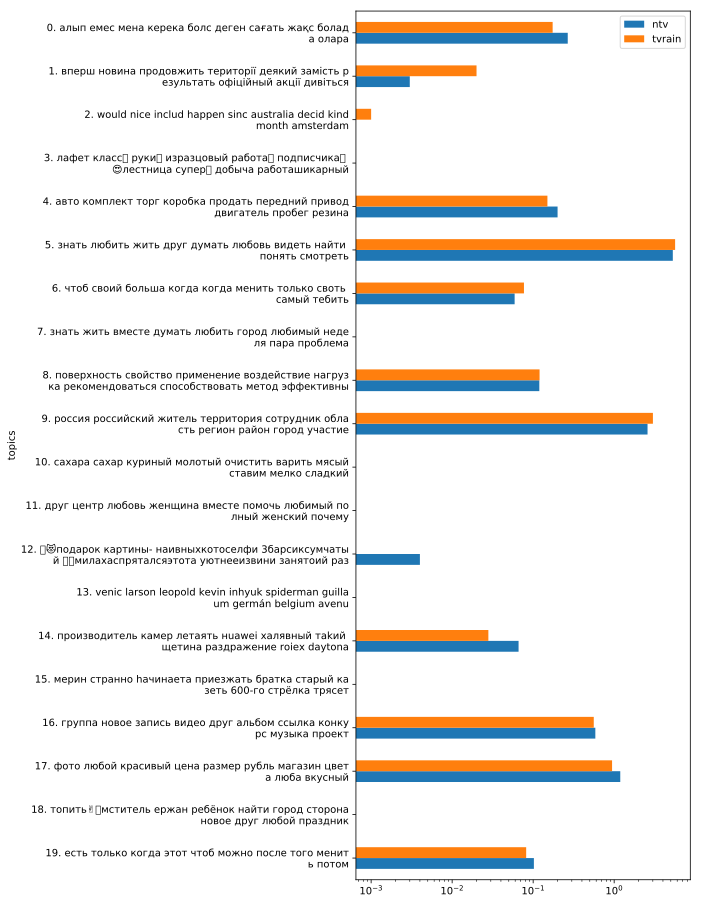

In [138]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
ntv_vs_tvrain_df.iloc[::-1].plot(x = 'topics', y=['ntv', 'tvrain'], kind='barh', logx=True, figsize=(6,16))

Как видно - разница между подписчиками 'НТВ' и 'Дождя' - несущественная.<br>
Основные различия:<br>
I. Топик 1. Украинские паблики. У Дождя гораздо больше пользователей, подписанных на эти паблики.<br>
II. Топик 2. Музыка, в основном клубная. Практически отсутствует у 'НТВ', небольшая доля у 'Дождя'.<br>
III. Топик 12. Мемасики, картиночки. Практически отсутствует у 'Дождя', небольшая доля у 'НТВ'.

### PCA. Топ 5 компонент.

Создадим DataFrame с пользователями и пабликами отдельно для 'Дождя' и 'НТВ'.

In [20]:
from sklearn.decomposition import PCA

In [98]:
ntv_user_group_df = pd.DataFrame(index=ntv_uids_sample, columns=groups_freq_dict.keys(), 
        data=np.zeros((len(ntv_uids_sample), len(groups_freq_dict.keys()))))

for user_data in final_data:
    uid = user_data['uid']
    if uid in ntv_uids_set:
        for group in user_data['items']:
            ntv_user_group_df.loc[uid, group] = 1
ntv_user_group_df.shape

(1000, 4349)

Удалим нулевые столбцы и строки

In [99]:
ntv_user_group_df = ntv_user_group_df.loc[(ntv_user_group_df != 0).any(axis=1), \
    (ntv_user_group_df != 0).any(axis=0)]
ntv_user_group_df.shape

(715, 2466)

Text(0, 0.5, 'explained_variance_ratio_')

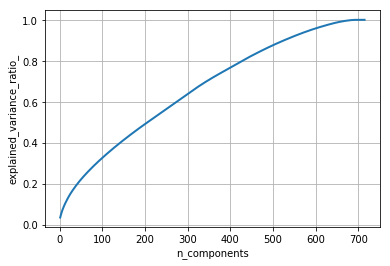

In [100]:
pca_ntv = PCA().fit(ntv_user_group_df)

cum_evr = np.cumsum(pca_ntv.explained_variance_ratio_)
xs = np.arange(cum_evr.size)+ 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Как видно из графика, для объяснения большей части дисперсии потребуется довольно-таки много компонент.<br>
И первые 5 компонент объясняют незначительную часть дисперсии.

In [101]:
pca_ntv.explained_variance_ratio_[:5]

array([0.03501963, 0.0086055 , 0.00729714, 0.00681818, 0.00677449])

In [102]:
pca_ntv.explained_variance_ratio_[:5].sum()

0.0645149448734464

Посмотрим топ 5 составляющих 5-ти первых компонент:

In [103]:
pca_ntv_top_5 = PCA(n_components=5).fit(ntv_user_group_df)

In [104]:
for comp in pca_ntv_top_5.components_:
    print(sorted(comp)[-5:][::-1])

[0.9619939194839179, 0.11862800575647879, 0.0932663246180958, 0.07342478608608849, 0.061276486688321335]
[0.8991020864929788, 0.10617324585400133, 0.09298344915690164, 0.08268143081403326, 0.0765927470621581]
[0.8114106479499893, 0.22453099357544404, 0.19194555441627767, 0.12815319778035283, 0.12080239811772144]
[0.5140874921905637, 0.42414188849041773, 0.31402053821867165, 0.24862159555473662, 0.18346139614419907]
[0.6985460696796737, 0.2962438844969953, 0.23803299197692507, 0.2112309208296634, 0.19612994290826433]


In [105]:
top_5_ntv_topics_index = []
for comp in pca_ntv_top_5.components_:
    top_5_ntv_topics_index.extend(comp.argsort()[-5:][::-1])

In [106]:
top_5_ntv_topics = ntv_user_group_df.columns[top_5_ntv_topics_index]

In [120]:
ntv_user_interests = {}
print("The most typical groups for ntv subscribers")
i = 1
for j, g in enumerate(top_5_ntv_topics):
    j+=1
    group_info = vk_get_response(
        'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
    )
    string = str(i) + '. ' + group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g)
    ntv_user_interests[j] = string
    if j%5==0:
        i+=1
    print(string)
    time.sleep(0.34)

The most typical groups for ntv subscribers
1. НТВ http://vk.com/club28658784
1. Warner Music Russia http://vk.com/club30462549
1. Jah Khalib http://vk.com/club26211015
1. РИА Новости http://vk.com/club15755094
1. Armin van Buuren http://vk.com/club42743690
2. Идеальная Хозяюшка http://vk.com/club68519692
2. Шпильки | Женский Журнал http://vk.com/club29686754
2. КиноКайф - Лучшие фильмы http://vk.com/club58170807
2. Женская логика | Психология http://vk.com/club39099241
2. Дизайн &amp; Декор http://vk.com/club51696572
3. РИА Новости http://vk.com/club15755094
3. БОРЩ http://vk.com/club460389
3. Комсомольская правда - KP.RU http://vk.com/club15722194
3. ВЕДОМОСТИ http://vk.com/club15548215
3. Газета.Ru http://vk.com/club20169232
4. Warner Music Russia http://vk.com/club30462549
4. Jah Khalib http://vk.com/club26211015
4. Armin van Buuren http://vk.com/club42743690
4. РИА Новости http://vk.com/club15755094
4. Радио ENERGY (NRJ) http://vk.com/club9693056
5. БОРЩ http://vk.com/club460389
5

Тоже самое для 'Дождя'.

In [108]:
tvrain_user_group_df = pd.DataFrame(index=tvrain_uids_sample, columns=groups_freq_dict.keys(), 
        data=np.zeros((len(tvrain_uids_sample), len(groups_freq_dict.keys()))))

for user_data in final_data:
    uid = user_data['uid']
    if uid in tvrain_uids_set:
        for group in user_data['items']:
            tvrain_user_group_df.loc[uid, group] = 1
tvrain_user_group_df.shape

(1000, 4349)

In [109]:
tvrain_user_group_df = tvrain_user_group_df.loc[(tvrain_user_group_df != 0).any(axis=1), \
    (tvrain_user_group_df != 0).any(axis=0)]
tvrain_user_group_df.shape

(738, 2309)

Text(0, 0.5, 'explained_variance_ratio_')

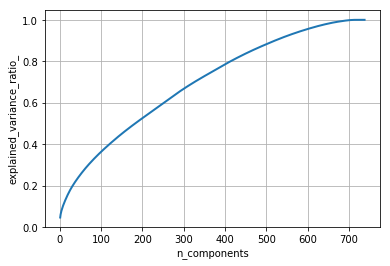

In [110]:
pca_tvrain = PCA().fit(tvrain_user_group_df)

cum_evr = np.cumsum(pca_tvrain.explained_variance_ratio_)
xs = np.arange(cum_evr.size)+ 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Как видно из графика, для объяснения большей части дисперсии потребуется довольно-таки много компонент.<br>
И первые 5 компонент объясняют незначительную часть дисперсии.

In [111]:
pca_tvrain.explained_variance_ratio_[:5]

array([0.04590317, 0.01474818, 0.00982008, 0.00780482, 0.0066464 ])

In [112]:
pca_tvrain.explained_variance_ratio_[:5].sum()

0.08492265166047175

Посмотрим топ 5 составляющих 5-ти первых компонент:

In [113]:
pca_tvrain_top_5 = PCA(n_components=5).fit(tvrain_user_group_df)

In [114]:
for comp in pca_tvrain_top_5.components_:
    print(sorted(comp)[-5:][::-1])

[0.973304655206949, 0.07677903392253527, 0.06417510956909245, 0.039563696039109794, 0.03207435571482238]
[0.6007401978004829, 0.4721757276119416, 0.2903347145323663, 0.28126470338434806, 0.26246467805689233]
[0.8563144330353581, 0.31475340445141353, 0.12205039204976123, 0.0898423421481952, 0.0760770600209139]
[0.8310610491967572, 0.19416870825041055, 0.18464423313981632, 0.13203292180648582, 0.07942512573734775]
[0.5109210164312443, 0.31181368239849916, 0.14440680654090587, 0.13332141383416718, 0.12178876870402403]


In [115]:
top_5_tvrain_topics_index = []
for comp in pca_tvrain_top_5.components_:
    top_5_tvrain_topics_index.extend(comp.argsort()[-5:][::-1])

In [116]:
top_5_tvrain_topics = tvrain_user_group_df.columns[top_5_tvrain_topics_index]

In [121]:
tvrain_user_interests = {}
print("The most typical groups for tvrain subscribers")
i = 1
for j, g in enumerate(top_5_tvrain_topics):
    j+=1
    group_info = vk_get_response(
        'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
    )
    string = str(i) + '. ' + group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g)
    tvrain_user_interests[j] = string
    if j%5==0:
        i+=1
    print(string)
    time.sleep(0.34)

The most typical groups for tvrain subscribers
1. Телеканал Дождь http://vk.com/club17568841
1. РИА Новости http://vk.com/club15755094
1. Команда ВКонтакте http://vk.com/club22822305
1. Онлайн-кинотеатр ivi http://vk.com/club15106510
1. LIVE http://vk.com/club2158488
2. LIVE http://vk.com/club2158488
2. Новости из будущего http://vk.com/club356220
2. Онлайн-кинотеатр ivi http://vk.com/club15106510
2. BOBINA http://vk.com/club137417
2. Apple http://vk.com/club442
3. Лентач http://vk.com/club29534144
3. Настоящий Лентач http://vk.com/club125004421
3. «Медуза» http://vk.com/club76982440
3. MDK http://vk.com/club57846937
3. Пикабу http://vk.com/club31480508
4. РИА Новости http://vk.com/club15755094
4. Онлайн-кинотеатр ivi http://vk.com/club15106510
4. Фестиваль Аврора http://vk.com/club15260252
4. BBC News Russian - Русская служба Би-би-си Ньюз http://vk.com/club17842936
4. Анатолий Шарий | Новости | Украина | Sharij.net http://vk.com/club72718092
5. БОРЩ http://vk.com/club460389
5. Шпильк

Сравним интересы двух групп.

In [122]:
ntv_vs_tvrain_pca_df = pd.DataFrame([ntv_user_interests, tvrain_user_interests]).T
ntv_vs_tvrain_pca_df.columns = ['НТВ', 'Дождь']

In [123]:
ntv_vs_tvrain_pca_df

,НТВ,Дождь
1,1. НТВ http://vk.com/club28658784,1. Телеканал Дождь http://vk.com/club17568841
2,1. Warner Music Russia http://vk.com/club30462549,1. РИА Новости http://vk.com/club15755094
3,1. Jah Khalib http://vk.com/club26211015,1. Команда ВКонтакте http://vk.com/club22822305
4,1. РИА Новости http://vk.com/club15755094,1. Онлайн-кинотеатр ivi http://vk.com/club1510...
5,1. Armin van Buuren http://vk.com/club42743690,1. LIVE http://vk.com/club2158488
6,2. Идеальная Хозяюшка http://vk.com/club68519692,2. LIVE http://vk.com/club2158488
7,2. Шпильки | Женский Журнал http://vk.com/club...,2. Новости из будущего http://vk.com/club356220
8,2. КиноКайф - Лучшие фильмы http://vk.com/club...,2. Онлайн-кинотеатр ivi http://vk.com/club1510...
9,2. Женская логика | Психология http://vk.com/c...,2. BOBINA http://vk.com/club137417
10,2. Дизайн &amp; Декор http://vk.com/club51696572,2. Apple http://vk.com/club442


Основные интересы у аудиторий НТВ и Дождя согласно PCA:<br>
у НТВ:<br>
1) Новости, клубная музыка.<br>
2) Женские паблики. <br>
3) Новостные ресурсы.<br>
4) Клубная музыка.<br>
5) Развлекательные ресурсы.<br>

у Дождя:<br>
1) Новости, новости вконтакте.<br>
2) Различные развлекательные ресурсы (музыка, юмор, кино, техника). <br>
3) Новости, развлекательные ресурсы.<br>
4) Новости.<br>
5) Развлекательные ресурсы.<br>

Интересы схожи, но используются разные паблики (новости, музыка, кино).<br>
Развлекательные паблики частично совпадают.